📌 In this notebook, our main goal is to categorize product reviews into two distinct categories: positive and negative. To achieve this goal, we use various techniques of natural language processing and machine learning to analyze and classify the emotions expressed in the notebook accurately.

# Import Necessary Libraries

In [1]:
from nltk.corpus import stopwords

# Download stopwords if not downloaded
import nltk
nltk.download('stopwords')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#SVM - Support Vector Machine
from sklearn.svm import SVC

#Random forest
from sklearn.tree import export_text
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.metrics import make_scorer
from sklearn.utils.class_weight import compute_class_weight



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arnau\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import Dataset

In [2]:

import os
# Obtener el directorio actual del script
directorio_script = os.path.dirname(os.path.abspath(os.getcwd()))

# Construir la ruta al archivo CSV
ruta_csv_data = os.path.join(directorio_script, 'data', 'amazon_reviews.csv')

df = pd.read_csv(ruta_csv_data, sep=",")

#Eliminació de columnes innecesaries
df = df.drop('helpful_yes', axis=1)
df = df.drop('helpful_no', axis=1)
df = df.drop('total_vote', axis=1)
df = df.drop('score_pos_neg_diff', axis=1)
df = df.drop('score_average_rating', axis=1)
df = df.drop('wilson_lower_bound', axis=1)

df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff
0,0,NaN,4.0,No issues.,2014-07-23,138
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513


# Text Processing

In [3]:
def text_preprocessing(dataframe, dependent_var):
  # Normalizing Case Folding - Uppercase to Lowercase
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

  # Removing Punctuation
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('[^\w\s]','')

  # Removing Numbers
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('\d','')

  # StopWords
  sw = stopwords.words('english')
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

  # Remove Rare Words
  temp_df = pd.Series(' '.join(dataframe[dependent_var]).split()).value_counts()
  drops = temp_df[temp_df <= 1]
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops))

  # Lemmatize
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

  return dataframe

In [4]:
df = text_preprocessing(df, "reviewText")

C:\Users\arnau\AppData\Local\Temp\ipykernel_26652\1732848924.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('[^\w\s]','')
C:\Users\arnau\AppData\Local\Temp\ipykernel_26652\1732848924.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('\d','')


# Feature Engineering

In [5]:
# Función para asignar valores a una nueva columna según la condición
def asignar_valor(score):
    if score in [1, 2, 3]:
        return 'neg'
    elif score in [4, 5]:
        return 'pos'
    else:
        return None  # Manejo de otros valores si los hay

# Aplicar la función a la columna 'score' para crear una nueva columna 'nueva_columna'
df['label'] = df['overall'].apply(asignar_valor)


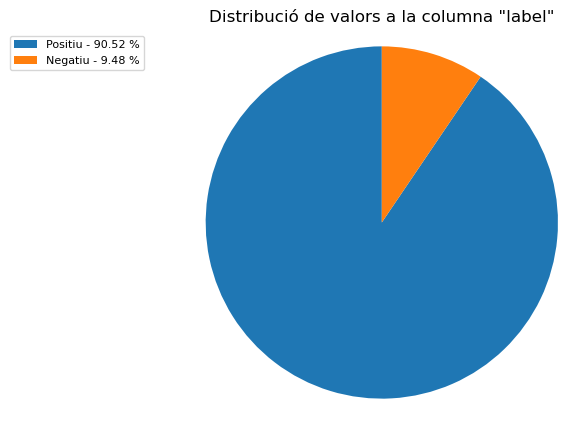

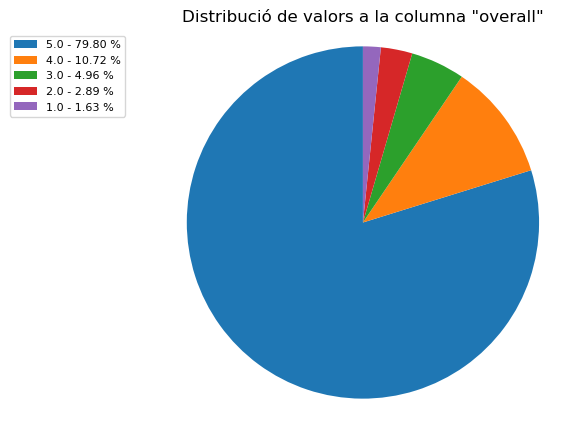

In [6]:
def grafic_distribucions():
    subset = df[df['label'].isin(['pos', 'neg'])]
    conteo = subset['label'].value_counts()
    

    #Pie chart grafic pos i neg
    plt.figure(figsize=(5, 5))
    valors, labels = plt.pie(conteo, startangle=90, radius=1.2)
    percent_conteto = conteo / len(subset) * 100
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(["Positiu","Negatiu"], percent_conteto)]
    plt.title('Distribució de valors a la columna "label"')
    plt.legend(valors, labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=8)
    plt.axis('equal')
    plt.show()
    
    #valors col 'overall'
    conteo = df['overall'].value_counts()
    percent_conteto = conteo / len(subset) * 100

    # Pie chart grafic overall
    plt.figure(figsize=(5, 5))
    valors, overall = plt.pie(conteo, startangle=90, radius=1.2)
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(["5.0","4.0","3.0","2.0","1.0"], percent_conteto)]
    plt.title('Distribució de valors a la columna "overall"')
    plt.legend(valors, labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=8)
    plt.axis('equal')  
    plt.show()


grafic_distribucions()

In [7]:
# Split Dataset
def split_dataset(dataframe, X, y, test_size=0.2, random_state=1):
  train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=1)
  return train_x, test_x, train_y, test_y

In [8]:
#Declaracio de conjunts train/test

x = df["reviewText"]
df['label'] = df['label'].map({'neg': 0, 'pos': 1})

y = df['label']

train_x, test_x, train_y, test_y = split_dataset(df, x, y)


In [9]:
def create_features_count(train_x, test_x, parameters):
  # Count Vectors

  #Max_df: ignore terms that appear in more than 90% of the documents
  #Min_df: ignore terms that appear in less than 0.01% of the documents
  #Max_features: consider top 5000 terms
  #Ngram_range: consider unigrams and bigrams
  #Binary: if True all non zero counts are set to 1 (useful for discrete probabilistic models) (not in this case but just in case)
  #Stop_words: remove stop words
  #CountVectorizer: Convert a collection of text documents to a matrix of token counts

  #max featuires

  vectorizer = CountVectorizer(min_df=parameters["min_df"], max_features=25)
  x_train_count_vectorizer = vectorizer.fit_transform(train_x)
  x_test_count_vectorizer = vectorizer.fit_transform(test_x)

  return x_train_count_vectorizer, x_test_count_vectorizer

In [10]:
optimal_param_countvectorizer = {"min_df": 0.0015}  #Gràcies a la funció anterior hem trobat el valor òptim de min_df (elbow graph)
x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x, optimal_param_countvectorizer)

In [11]:
def create_features_TFIDF_word(train_x, test_x):
  # TF-IDF word
  
  #Max_df: ignore terms that appear in more than 90% of the documents
  #Min_df: ignore terms that appear in less than 0.01% of the documents
  #Max_features: consider top 5000 terms
  #Ngram_range: consider unigrams and bigrams
  #Stop_words: remove stop words
  #TfidfVectorizer: Convert a collection of raw documents to a matrix of TF-IDF features
  #Aquest mira la freqüència de les paraules soles
  
  tf_idf_word_vectorizer = TfidfVectorizer( max_df=0.9, min_df=0.01, max_features=300, stop_words='english')
  x_train_tf_idf_word = tf_idf_word_vectorizer.fit_transform(train_x)
  x_test_tf_idf_word = tf_idf_word_vectorizer.fit_transform(test_x)

  return x_train_tf_idf_word, x_test_tf_idf_word

In [12]:
x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)

In [13]:
def create_features_TFIDF_ngram(train_x, test_x):
  # TF-IDF ngram

  #Aquest mira la freqüència de les paraules en parelles i trios
  tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2,3), max_features=45000)
  x_train_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(train_x)
  x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(test_x)

  return x_train_tf_idf_ngram, x_test_tf_idf_ngram

In [14]:
x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)

C:\Users\arnau\AppData\Local\Temp\ipykernel_26652\417562648.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'vectorizer': 'Count vectorizer', 'n_features': i, 'f1_score': f1_score_tf_idf_word, 'specificity': specificity}, ignore_index=True)
C:\Users\arnau\AppData\Local\Temp\ipykernel_26652\417562648.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'vectorizer': 'Count vectorizer', 'n_features': i, 'f1_score': f1_score_tf_idf_word, 'specificity': specificity}, ignore_index=True)
C:\Users\arnau\AppData\Local\Temp\ipykernel_26652\417562648.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'vectorizer': 'Count vectorizer', 'n_features': i, 'f1_score': f1_score_tf_idf_w

,vectorizer,n_features,f1_score,specificity
0,Count vectorizer,25,0.763926,0.606061
1,Count vectorizer,50,0.783470,0.676768
2,Count vectorizer,100,0.705647,0.303030
3,Count vectorizer,250,0.800370,0.171717
4,Count vectorizer,500,0.849749,0.494949
5,Count vectorizer,1000,0.826292,0.181818
6,Count vectorizer,2500,0.866637,0.030303
7,TF-IDF word,25,0.796550,0.545455
8,TF-IDF word,50,0.818518,0.606061
9,TF-IDF word,100,0.680632,0.404040


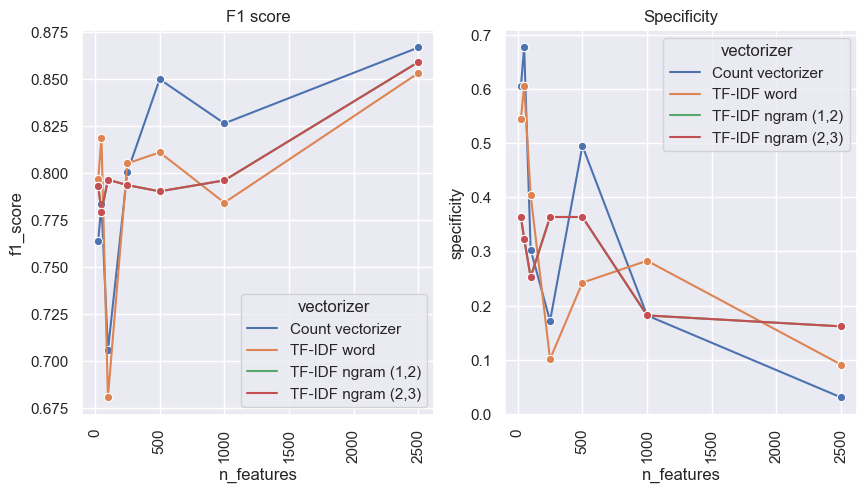

In [15]:
#Gràfica de f1 en logistic regression segons el mètode de vectorització i el seu n_features
def grafic_f1_score_logistic_regression():
    df = pd.DataFrame(columns=['vectorizer', 'n_features', 'f1_score', 'specificity'])
    #Count vectorizer amb range max_features
    max_features_range = [25, 50, 100, 250, 500, 1000, 2500]

    for i in max_features_range:
        tf_idf_word_vectorizer = TfidfVectorizer(max_features=i)
        x_train_tf_idf_word = tf_idf_word_vectorizer.fit_transform(train_x)
        x_test_tf_idf_word = tf_idf_word_vectorizer.fit_transform(test_x)
        lr = LogisticRegression(class_weight='balanced')
        lr.fit(x_train_tf_idf_word, train_y)
        y_pred = lr.predict(x_test_tf_idf_word)
        f1_score_tf_idf_word = f1_score(test_y, y_pred, average='weighted')
        tn, fp, fn, tp = confusion_matrix(test_y, y_pred).ravel()
        specificity = tn / (tn+fp)
        df = df.append({'vectorizer': 'Count vectorizer', 'n_features': i, 'f1_score': f1_score_tf_idf_word, 'specificity': specificity}, ignore_index=True)


    for i in max_features_range:
        vectorizer = CountVectorizer(max_features=i)
        x_train_count_vectorizer = vectorizer.fit_transform(train_x)
        x_test_count_vectorizer = vectorizer.fit_transform(test_x)
        lr = LogisticRegression(class_weight='balanced')
        lr.fit(x_train_count_vectorizer, train_y)
        y_pred = lr.predict(x_test_count_vectorizer)
        f1_score_count_vectorizer = f1_score(test_y, y_pred, average='weighted')
        tn, fp, fn, tp = confusion_matrix(test_y, y_pred).ravel()
        specificity = tn / (tn+fp)
        df = df.append({'vectorizer': 'TF-IDF word', 'n_features': i, 'f1_score': f1_score_count_vectorizer, 'specificity': specificity}, ignore_index=True)
    
    #TF-IDF ngram amb range max_features
    for i in max_features_range:
        tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2,3), max_features=i)
        x_train_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(train_x)
        x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(test_x)
        lr = LogisticRegression(class_weight='balanced')
        lr.fit(x_train_tf_idf_ngram, train_y)
        y_pred = lr.predict(x_test_tf_idf_ngram)
        f1_score_tf_idf_ngram = f1_score(test_y, y_pred, average='weighted')
        tn, fp, fn, tp = confusion_matrix(test_y, y_pred).ravel()
        specificity = tn / (tn+fp)
        df = df.append({'vectorizer': 'TF-IDF ngram (1,2)', 'n_features': i, 'f1_score': f1_score_tf_idf_ngram, 'specificity': specificity}, ignore_index=True)

    #TF-IDF ngram (2,3) amb range max_features
    for i in max_features_range:
        tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2,3), max_features=i)
        x_train_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(train_x)
        x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(test_x)
        lr = LogisticRegression(class_weight='balanced')
        lr.fit(x_train_tf_idf_ngram, train_y)
        y_pred = lr.predict(x_test_tf_idf_ngram)
        f1_score_tf_idf_ngram = f1_score(test_y, y_pred, average='weighted')
        tn, fp, fn, tp = confusion_matrix(test_y, y_pred).ravel()
        specificity = tn / (tn+fp)
        df = df.append({'vectorizer': 'TF-IDF ngram (2,3)', 'n_features': i, 'f1_score': f1_score_tf_idf_ngram, 'specificity': specificity}, ignore_index=True)

    
    display(df)

    #Grafic f1 score i specificity segons el vectorizer amb sns lineplot
    sns.set(style="darkgrid")
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.lineplot(x='n_features', y='f1_score', hue='vectorizer', marker='o',data=df)
    plt.title("F1 score")
    plt.xticks(rotation=90)
    plt.subplot(1, 2, 2)
    sns.lineplot(x='n_features', y='specificity', hue='vectorizer', marker='o', data=df)
    plt.title("Specificity")
    plt.xticks(rotation=90)
    plt.show()




    

grafic_f1_score_logistic_regression()

C:\Users\arnau\AppData\Local\Temp\ipykernel_26652\2852346920.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'min_df': i, 'max_df': j, 'f1_score': f1_score_count_vectorizer, 'specificity': specificity}, ignore_index=True)
C:\Users\arnau\AppData\Local\Temp\ipykernel_26652\2852346920.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'min_df': i, 'max_df': j, 'f1_score': f1_score_count_vectorizer, 'specificity': specificity}, ignore_index=True)
C:\Users\arnau\AppData\Local\Temp\ipykernel_26652\2852346920.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'min_df': i, 'max_df': j, 'f1_score': f1_score_count_vectorizer, 'specificity': specificity}, ignore_index=True)
C:\U

,min_df,max_df,f1_score,specificity
0,0.0010,0.90,0.79655,0.545455
1,0.0010,0.75,0.79655,0.545455
2,0.0010,0.55,0.79655,0.545455
3,0.0015,0.90,0.79655,0.545455
4,0.0015,0.75,0.79655,0.545455
5,0.0015,0.55,0.79655,0.545455
6,0.0020,0.90,0.79655,0.545455
7,0.0020,0.75,0.79655,0.545455
8,0.0020,0.55,0.79655,0.545455
9,0.0095,0.90,0.79655,0.545455


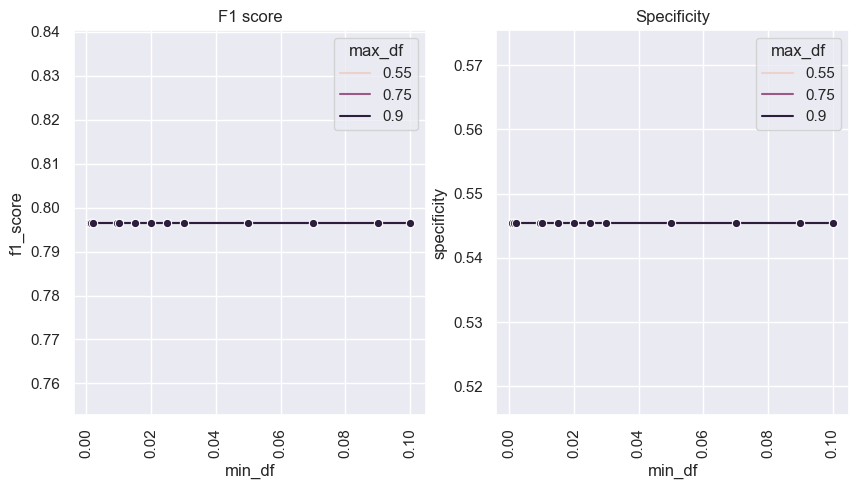

In [16]:
#Count vectorizer rang de min_df i max_df
def grafic_count_vectorizer():
    df = pd.DataFrame(columns=['min_df', 'max_df', 'f1_score', 'specificity'])
    min_df_range = [0.001, 0.0015, 0.002, 0.0095, 0.01, 0.015, 0.02, 0.025, 0.03, 0.05, 0.07, 0.09,0.1]
    max_df_range = [0.9, 0.75, 0.55]

    for i in min_df_range:
        for j in max_df_range:
            vectorizer = CountVectorizer(min_df=i, max_df=j, max_features=25)
            x_train_count_vectorizer = vectorizer.fit_transform(train_x)
            x_test_count_vectorizer = vectorizer.fit_transform(test_x)
            lr = LogisticRegression(class_weight='balanced')
            lr.fit(x_train_count_vectorizer, train_y)
            y_pred = lr.predict(x_test_count_vectorizer)
            f1_score_count_vectorizer = f1_score(test_y, y_pred, average='weighted')
            tn, fp, fn, tp = confusion_matrix(test_y, y_pred).ravel()
            specificity = tn / (tn+fp)
            df = df.append({'min_df': i, 'max_df': j, 'f1_score': f1_score_count_vectorizer, 'specificity': specificity}, ignore_index=True)

    display(df)

    #Grafic f1 score i specificity segons el vectorizer amb sns lineplot
    sns.set(style="darkgrid")
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.lineplot(x='min_df', y='f1_score', hue='max_df', marker='o',data=df)
    plt.title("F1 score")
    plt.xticks(rotation=90)
    plt.subplot(1, 2, 2)
    sns.lineplot(x='min_df', y='specificity', hue='max_df', marker='o', data=df)
    plt.title("Specificity")
    plt.xticks(rotation=90)
    plt.show()


grafic_count_vectorizer()

# Balanç del dataset


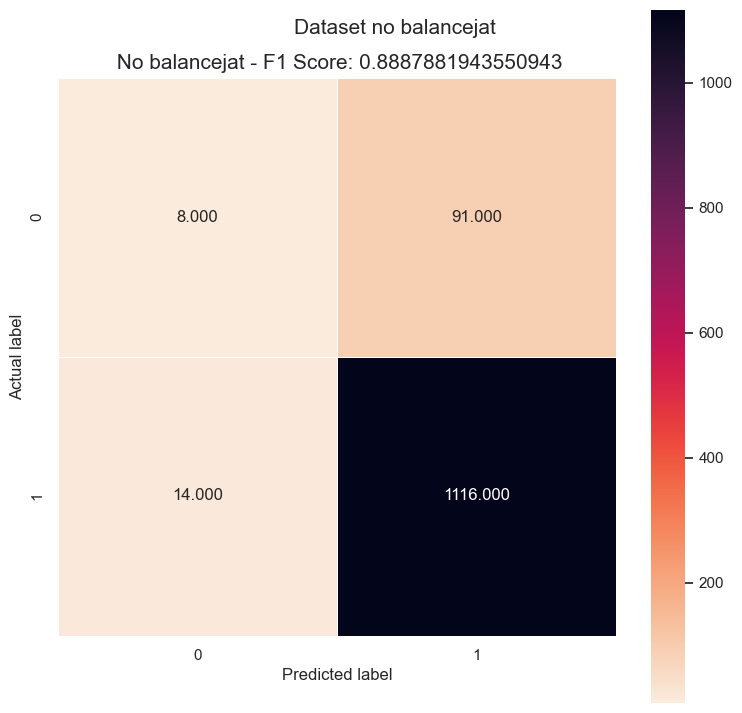

In [17]:
def log_unbalanced(train_x, test_x, train_y, test_y, parameters):
    # Usar las funciones para obtener características
    x_train_count, x_test_count = create_features_count(train_x, test_x, parameters)
    # Modelo de regresión logística con CountVectorizer
    logistic_model_count = LogisticRegression()
    logistic_model_count.fit(x_train_count, train_y)
    predictions_count = logistic_model_count.predict(x_test_count)
    f1_score_count = f1_score(test_y, predictions_count, average='weighted')
    confusion_matrix_count = confusion_matrix(test_y, predictions_count)
    # plot confusion matrix
    plt.figure(figsize=(9,9))
    sns.heatmap(confusion_matrix_count, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'rocket_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = ' No balancejat - F1 Score: {0}'.format(f1_score_count)
    plt.title(all_sample_title, size = 15)
    # subtititle and where to place it
    plt.suptitle('Dataset no balancejat', size = 15, y = 0.87)
    plt.show()




log_unbalanced(train_x, test_x, train_y, test_y, optimal_param_countvectorizer)

In [18]:
def log_balanced(train_x, test_x, train_y, test_y, parameters, class_weights ):
    # Usar las funciones para obtener características
    x_train_count, x_test_count = create_features_count(train_x, test_x, parameters)
    # Modelo de regresión logística con CountVectorizer
    if class_weights == 'balanced': 
        print(compute_class_weight(class_weight='balanced', classes=np.unique(train_y), y=train_y))
    logistic_model_count = LogisticRegression(class_weight=class_weights)
    logistic_model_count.fit(x_train_count, train_y)
    predictions_count = logistic_model_count.predict(x_test_count)
    f1_score_count = f1_score(test_y, predictions_count, average='weighted')
    confusion_matrix_count = confusion_matrix(test_y, predictions_count)
    # plot confusion matrix
    """   plt.figure(figsize=(9,9))
    sns.heatmap(confusion_matrix_count, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'rocket_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'F1 Score: {0}'.format(f1_score_count)
    plt.title(all_sample_title, size = 15)
    plt.suptitle('class_weight = "balanced"', size = 15, y = 0.87)

    plt.show() """

    return confusion_matrix_count


log_balanced(train_x, test_x, train_y, test_y, optimal_param_countvectorizer, "balanced")

[5.02179837 0.55528774]


array([[ 54,  45],
       [272, 858]], dtype=int64)

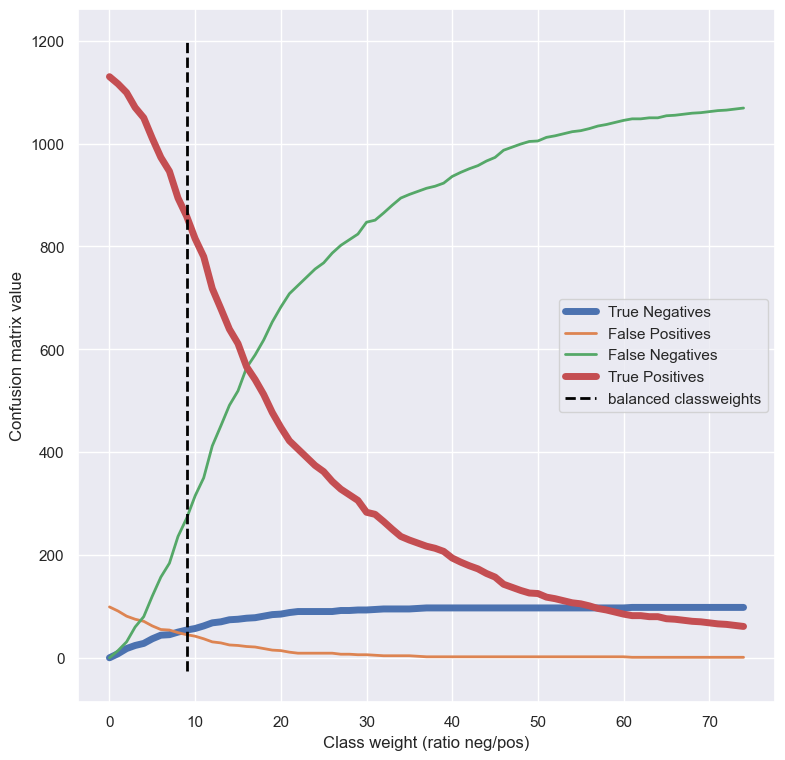

In [19]:
# save confusion matrixes of diferent classweights in a list
tbal = 5.02179837/0.55528774 #ratio neg/pos
results= None
results = {}
for i in range (0,75, 1):
    class_weights = {0: i, 1: 1}
    confusion_mat = log_balanced(train_x, test_x, train_y, test_y, optimal_param_countvectorizer, class_weights)
    results[i] = confusion_mat
    #save confusion matrixes values in a list

# plot confusion matrixes values for diferent classweights
plt.figure(figsize=(9,9))
plt.plot(results.keys(), [x[0][0] for x in results.values()], label = "True Negatives", linewidth=5)
plt.plot(results.keys(), [x[0][1] for x in results.values()], label = "False Positives", linewidth=2)
plt.plot(results.keys(), [x[1][0] for x in results.values()], label = "False Negatives", linewidth=2)
plt.plot(results.keys(), [x[1][1] for x in results.values()], label = "True Positives", linewidth=5)
#plot tbal line
plt.plot([tbal, tbal], [-25, 1200], label = "balanced classweights", linewidth=2, color='black', linestyle='dashed')
plt.xlabel("Class weight (ratio neg/pos)")
plt.ylabel("Confusion matrix value")
plt.legend()
plt.show()



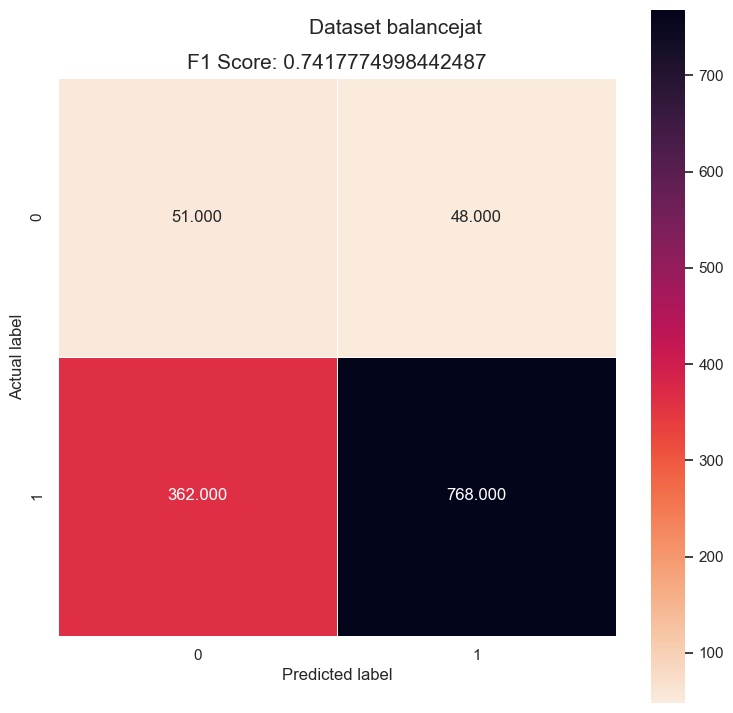

In [20]:
def log_balanced2(train_x, test_x, train_y, test_y, optimal_param_countvectorizer):
    #  crear un dataset balanceado 50-50 from train_x, train_y, test_x, test_y
    df_balanced = pd.concat([train_x, train_y], axis=1)
    df_balanced = df_balanced.groupby('label').apply(lambda x: x.sample(n=367, random_state=1))
    df_balanced = df_balanced.reset_index(drop=True)
    train_x_balanced = df_balanced['reviewText']
    train_y_balanced = df_balanced['label']
    # Usar las funciones para obtener características
    x_train_count, x_test_count = create_features_count(train_x_balanced, test_x, optimal_param_countvectorizer)
    # Modelo de regresión logística con CountVectorizer
    logistic_model_count = LogisticRegression()
    logistic_model_count.fit(x_train_count, train_y_balanced)
    predictions_count = logistic_model_count.predict(x_test_count)
    f1_score_count = f1_score(test_y, predictions_count, average='weighted')
    confusion_matrix_count = confusion_matrix(test_y, predictions_count)
    # plot confusion matrix
    plt.figure(figsize=(9,9))
    sns.heatmap(confusion_matrix_count, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'rocket_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'F1 Score: {0}'.format(f1_score_count)
    plt.title(all_sample_title, size = 15)
    plt.suptitle('Dataset balancejat', size = 15, y = 0.87)
    plt.show()

log_balanced2(train_x, test_x, train_y, test_y, optimal_param_countvectorizer)


# Logistic Model

In [21]:
def create_model_logistic(train_x, test_x, train_y, test_y, parameters):
  # Usar las funciones para obtener características
  x_train_count, x_test_count = create_features_count(train_x, test_x, parameters)

  # Modelo de regresión logística con CountVectorizer
  logistic_model_count = LogisticRegression(class_weight='balanced')
  logistic_model_count.fit(x_train_count, train_y)
  predictions_count = logistic_model_count.predict(x_test_count)
  f1_score_count = f1_score(test_y, predictions_count, average='weighted')
  print("F1 Score using CountVectorizer:", f1_score_count)
  # specifity
  tn, fp, fn, tp = confusion_matrix(test_y, predictions_count).ravel()
  specifity = tn / (tn+fp)
  print("Specifity:", specifity)


  return logistic_model_count

In [22]:
parameters = {"max_df_values": 1.0, "min_df": 0.1, "max_features": 5000}
loj_model_count = create_model_logistic(train_x, test_x, train_y, test_y, parameters)

F1 Score using CountVectorizer: 0.79654996722932
Specifity: 0.5454545454545454


# Random Forest

In [23]:
# Random Forest
def create_model_randomforest(train_x, test_x, train_y, test_y, parameters):
    # Count
    n_estimators = parameters["n_estimators"]
    max_features = parameters["max_features"]
    max_depth = parameters["max_depth"]
    rf_count = RandomForestClassifier(class_weight='balanced', n_estimators=n_estimators, max_features=max_features, max_depth=max_depth)
    # Defineix la mètrica 'f1_weighted' per utilitzar-la amb cross_val_score
    f1_weighted_scorer = make_scorer(f1_score, average='weighted')
    # Entrena el model RandomForest
    rf_model_count = rf_count.fit(x_train_count_vectorizer, train_y)
    # Prediccions amb les dades de prova
    predictions_count = rf_model_count.predict(x_test_count_vectorizer)
    # Calcula el F1 score mitjançant cross_val_score
    f1_score_count = cross_val_score(rf_model_count, x_test_count_vectorizer, test_y, cv=10, scoring=f1_weighted_scorer).mean()
    # specifity
    tn, fp, fn, tp = confusion_matrix(test_y, predictions_count).ravel()
    specifity = tn / (tn+fp)
    # if max_depth not exists
    if parameters["max_depth"] == None:
        max_depth = "None"
    results_RF.loc[len(results_RF)] = [ n_estimators, max_features, max_depth, f1_score_count, specifity]

    return None



In [24]:
results_RF = pd.DataFrame(columns=["n_estimators", "max_features", "Max depth", "F1 score", "Specifity"])

# Després pots utilitzar aquestes característiques per al teu model RandomForest
parameters = {"max_df_values": 1.0, "min_df": 0.1, "max_features": 25, "n_estimators": 200, "max_depth": None}
for i in range(1, 1000, 100):
    parameters["n_estimators"] = i
    create_model_randomforest(train_x, test_x, train_y, test_y, parameters)

print(results_RF)


KeyboardInterrupt: 

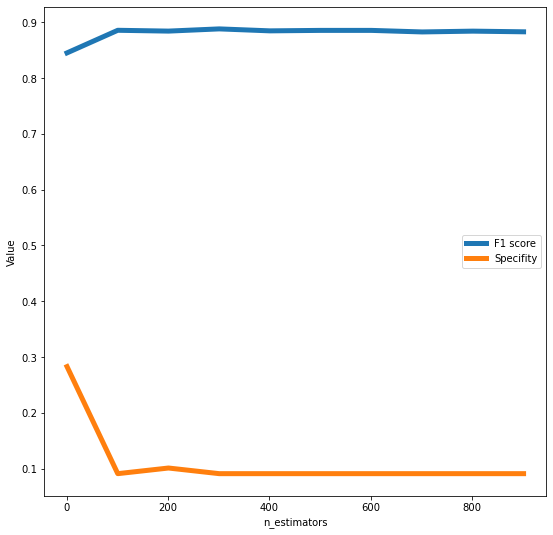

In [ ]:
# plot f1 and specifity for diferent n_estimators
plt.figure(figsize=(9,9))
plt.plot(results_RF['n_estimators'], results_RF['F1 score'], label = "F1 score", linewidth=5)
plt.plot(results_RF['n_estimators'], results_RF['Specifity'], label = "Specifity", linewidth=5)
plt.xlabel("n_estimators")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
results_RF = pd.DataFrame(columns=["n_estimators", "max_features", "Max depth", "F1 score", "Specifity"])

# Després pots utilitzar aquestes característiques per al teu model RandomForest
parameters = {"max_df_values": 1.0, "min_df": 0.1, "max_features": 25, "n_estimators": 10, "max_depth": None}
for i in range(1, 1000, 100):
    parameters["max_depth"] = i
    create_model_randomforest(train_x, test_x, train_y, test_y, parameters)

print(results_RF)

   n_estimators  max_features  Max depth  F1 score  Specifity
0          10.0          25.0        1.0  0.751358   0.474747
1          10.0          25.0      101.0  0.878040   0.141414
2          10.0          25.0      201.0  0.884169   0.131313
3          10.0          25.0      301.0  0.877836   0.181818
4          10.0          25.0      401.0  0.880318   0.141414
5          10.0          25.0      501.0  0.881615   0.141414
6          10.0          25.0      601.0  0.881513   0.161616
7          10.0          25.0      701.0  0.877261   0.111111
8          10.0          25.0      801.0  0.887508   0.121212
9          10.0          25.0      901.0  0.884135   0.161616


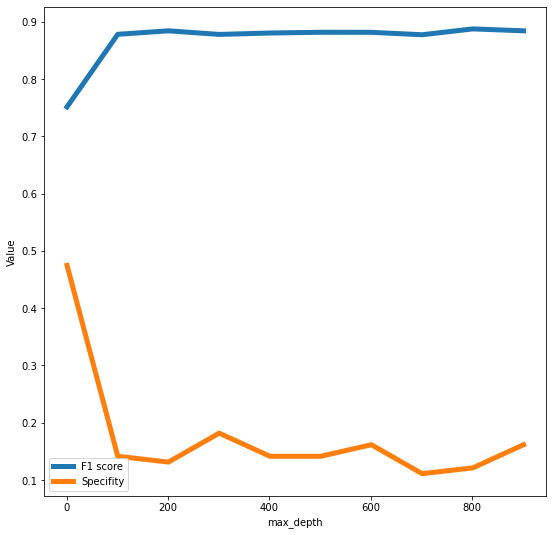

In [ ]:
# plot f1 and specifity for diferent n_estimators
plt.figure(figsize=(9,9))
plt.plot(results_RF['Max depth'], results_RF['F1 score'], label = "F1 score", linewidth=5)
plt.plot(results_RF['Max depth'], results_RF['Specifity'], label = "Specifity", linewidth=5)
plt.xlabel("max_depth")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
results_RF = pd.DataFrame(columns=["n_estimators", "max_features", "Max depth", "F1 score", "Specifity"])

# Després pots utilitzar aquestes característiques per al teu model RandomForest
parameters = {"max_df_values": 1.0, "min_df": 0.1, "max_features": 25, "n_estimators": 200, "max_depth": 5}
for i in range(1, 25, 1):
    parameters["max_features"] = i
    create_model_randomforest(train_x, test_x, train_y, test_y, parameters)

print(results_RF)

    n_estimators  max_features  Max depth  F1 score  Specifity
0          200.0           1.0        5.0  0.884473   0.353535
1          200.0           2.0        5.0  0.869291   0.444444
2          200.0           3.0        5.0  0.870149   0.414141
3          200.0           4.0        5.0  0.867810   0.434343
4          200.0           5.0        5.0  0.862842   0.393939
5          200.0           6.0        5.0  0.864449   0.464646
6          200.0           7.0        5.0  0.861902   0.464646
7          200.0           8.0        5.0  0.857164   0.444444
8          200.0           9.0        5.0  0.852751   0.484848
9          200.0          10.0        5.0  0.858959   0.505051
10         200.0          11.0        5.0  0.851362   0.464646
11         200.0          12.0        5.0  0.849618   0.434343
12         200.0          13.0        5.0  0.854182   0.464646
13         200.0          14.0        5.0  0.854052   0.525253
14         200.0          15.0        5.0  0.848979   0

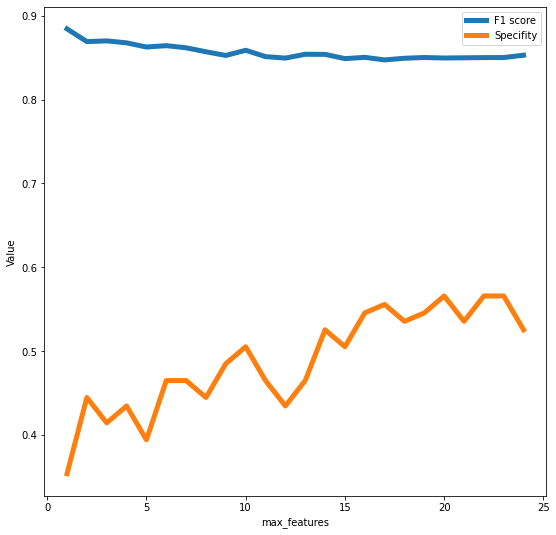

In [ ]:
# plot f1 and specifity for diferent n_estimators
plt.figure(figsize=(9,9))
plt.plot(results_RF['max_features'], results_RF['F1 score'], label = "F1 score", linewidth=5)
plt.plot(results_RF['max_features'], results_RF['Specifity'], label = "Specifity", linewidth=5)
plt.xlabel("max_features")
plt.ylabel("Value")
plt.legend()
plt.show()

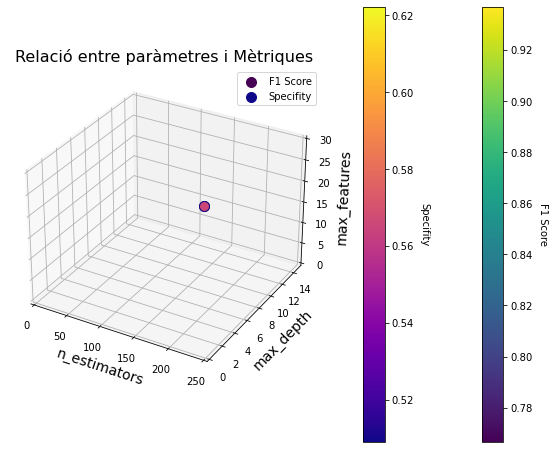

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Dades
max_depth = 5.0
max_features = 25.0
n_estimators = 200.0
f1_score = 0.851774
specifity = 0.565657

# Crear el gràfic de dispersió 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Afegir els punts amb grandària i color diferents
scatter_f1 = ax.scatter(n_estimators, max_depth, max_features, c=f1_score, cmap='viridis', s=100, label='F1 Score')
scatter_specifity = ax.scatter(n_estimators, max_depth, max_features, c=specifity, cmap='plasma', s=100, label='Specifity')

# Configurar els títols i les etiquetes
ax.set_title('Relació entre paràmetres i Mètriques', fontsize=16)
ax.set_xlabel('n_estimators', fontsize=14)
ax.set_ylabel('max_depth', fontsize=14)
ax.set_zlabel('max_features', fontsize=14)
ax.set_xlim([0, 250])  # Ajusta els límits segons els teus valors
ax.set_ylim([0, 15])
ax.set_zlim([0, 30])

# Afegir la barra de color
cbar_f1 = plt.colorbar(scatter_f1, ax=ax, pad=0.1)
cbar_f1.set_label('F1 Score', rotation=270, labelpad=15)

cbar_specifity = plt.colorbar(scatter_specifity, ax=ax, pad=0.1)
cbar_specifity.set_label('Specifity', rotation=270, labelpad=15)

# Mostrar llegenda
ax.legend()

plt.show()


In [ ]:
# Random Forest
def create_model_randomforest(train_x, test_x, train_y, test_y, parameters, max_depth=None):
    # Count
    rf_count = RandomForestClassifier(max_depth=max_depth, class_weight='balanced')
    # Obtenir els pesos de classe per a assegurar-se que estan ben equilibrats
    class_weights = compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)
    # Defineix la mètrica 'f1_weighted' per utilitzar-la amb cross_val_score
    f1_weighted_scorer = make_scorer(f1_score, average='weighted')
    # Entrena el model RandomForest
    rf_model_count = rf_count.fit(x_train_count_vectorizer, train_y)
    # Prediccions amb les dades de prova
    predictions_count = rf_model_count.predict(x_test_count_vectorizer)
    # Calcula el F1 score mitjançant cross_val_score
    f1_score_count = cross_val_score(rf_model_count, x_test_count_vectorizer, test_y, cv=10, scoring=f1_weighted_scorer).mean()
    results_RF_depht_balanced.loc[len(results_RF_depht_balanced)] = [ max_depth, f1_score_count]


    print(results_RF_depht_balanced)

In [ ]:
# Després pots utilitzar aquestes característiques per al teu model RandomForest
parameters = {"max_df_values": 1.0, "min_df": 0.1}
create_model_randomforest(train_x, test_x, train_y, test_y, parameters, max_depth=1000)

   Max depth  F1 score
0       10.0  0.884060
1       50.0  0.883880
2      100.0  0.878787
3      200.0  0.877425
4      500.0  0.879842
5     1000.0  0.885629


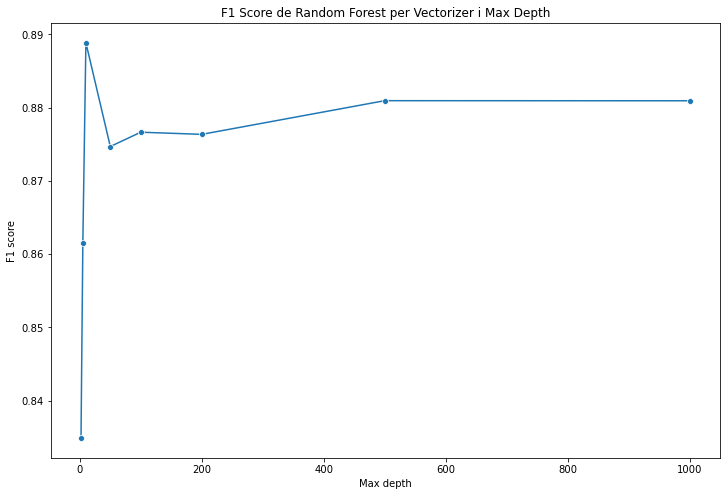

In [ ]:
# Crear una figura
plt.figure(figsize=(12, 8))

# Crear la gràfica de línies i punts amb Seaborn
sns.lineplot(x='Max depth', y='F1 score', data=results_RF_depht_balanced, marker='o', palette='viridis')

# Afegir títol
plt.title('F1 Score de Random Forest per Vectorizer i Max Depth')

# Mostrar la gràfica
plt.show()


## N_estimators

In [ ]:

# Definició de paràmetres per a la funció CountVectorizer
optimal_param_countvectorizer = {"min_df": 0.01, "max_features": 5000}

# Assumeix que 'results_RF' és un DataFrame ja creat abans d'aquesta funció
results_RF_balanced = pd.DataFrame(columns=["n_estimators", "max_depth", "f1_score"])

# Random Forest
def create_model_randomforest(train_x, test_x, train_y, test_y, parameters, n_estimators_list=[10, 50, 100, 200, 500, 1000], max_depth=None):
    for n_estimators in n_estimators_list:
        # Random Forest amb diferents nombres d'arbres
        rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight='balanced', random_state=1)
        
        # Obtenir els pesos de classe per a assegurar-se que estan ben equilibrats
        class_weights = compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)
        
        # Defineix la mètrica 'f1_weighted' per utilitzar-la amb cross_val_score
        f1_weighted_scorer = make_scorer(f1_score, average='weighted')
        
        # Entrena el model RandomForest
        rf_model.fit(train_x, train_y)
        
        # Prediccions amb les dades de prova
        predictions = rf_model.predict(test_x)
        
        # Calcula el F1 score mitjançant cross_val_score
        f1_score_value = cross_val_score(rf_model, test_x, test_y, cv=10, scoring=f1_weighted_scorer).mean()
        
        # Afegeix els resultats al DataFrame
        results_RF_balanced.loc[len(results_RF_balanced)] = [n_estimators, max_depth, f1_score_value]

    print(results_RF_balanced)

# Exemple d'ús:
x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x, optimal_param_countvectorizer)
create_model_randomforest(x_train_count_vectorizer, x_test_count_vectorizer, train_y, test_y, optimal_param_countvectorizer)


   n_estimators  max_depth  f1_score
0          10.0        NaN  0.874914
1          50.0        NaN  0.877363
2         100.0        NaN  0.880770
3         200.0        NaN  0.881251
4         500.0        NaN  0.879802
5        1000.0        NaN  0.881251


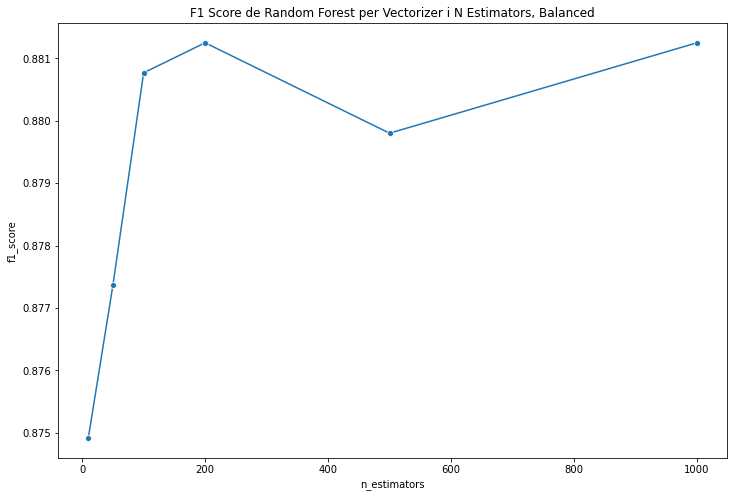

In [ ]:
# Crear una figura
plt.figure(figsize=(12, 8))

# Crear la gràfica de línies i punts amb Seaborn
sns.lineplot(x='n_estimators', y='f1_score', data=results_RF_balanced, marker='o', palette='viridis')

# plot specifity
sns.lineplot(x='n_estimators', y='specifity', data=results_RF_balanced, marker='o', palette='viridis')

# Afegir títol
plt.title('F1 Score de Random Forest per Vectorizer i N Estimators, Balanced')

# Mostrar la gràfica
plt.show()


## Max_features

In [ ]:

# Assume que 'results_RF' és un DataFrame ja creat abans d'aquesta funció
results_RF_features_balanced = pd.DataFrame(columns=["max_depth", "max_features", "f1_score"])

# Función para crear modelo Random Forest con parámetro max_features
def create_model_randomforest(train_x, test_x, train_y, test_y, parameters, max_features=None, max_depth=None):
    # Count
    rf_count = RandomForestClassifier(max_depth=max_depth, max_features=max_features, class_weight='balanced', random_state=1)
    # Obtener los pesos de clase para asegurarse de que están bien equilibrados
    class_weights = compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)
    # Define la métrica 'f1_weighted' para usar con cross_val_score
    f1_weighted_scorer = make_scorer(f1_score, average='weighted')
    # Entrenar el modelo RandomForest
    rf_model_count = rf_count.fit(train_x, train_y)  # Entrenar con train_x
    # Predicciones con los datos de prueba
    predictions_count = rf_model_count.predict(test_x)
    # Calcular el F1 score mediante cross_val_score
    f1_score_count = cross_val_score(rf_model_count, test_x, test_y, cv=10, scoring=f1_weighted_scorer).mean()
    results_RF_features_balanced.loc[len(results_RF_features_balanced)] = [max_depth, max_features, f1_score_count]

    print(results_RF_features_balanced)


In [ ]:
# Definición de parámetros para la función CountVectorizer
optimal_param_countvectorizer = {"min_df": 0.01, "max_features": 5000}

# Crear características con CountVectorizer
x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x, optimal_param_countvectorizer)

# Crear el modelo Random Forest con parámetro max_features
create_model_randomforest(x_train_count_vectorizer, x_test_count_vectorizer, train_y, test_y, optimal_param_countvectorizer, max_depth=None, max_features=25)


   max_depth  max_features  f1_score
0        NaN           2.0  0.875932
1        NaN           5.0  0.880770
2        NaN          10.0  0.884522
3        NaN          15.0  0.883730
4        NaN          20.0  0.882132
5        NaN          25.0  0.885471


# SVM

In [ ]:
# SVM
def create_model_svm(train_x, test_x, parameters,C=1.0,  kernel_type="linear", degree=3, gamma="auto"):
    # Count
    x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x, parameters)
    svm_count = SVC(kernel=kernel_type, degree=degree, C=C, gamma=gamma, class_weight='balanced')
    svm_model_count = svm_count.fit(x_train_count_vectorizer, train_y)
    f1_score_count = cross_val_score(svm_model_count, x_test_count_vectorizer, test_y, cv=10, scoring='f1_weighted').mean()
        
    return svm_model_count

# Visualització 2D

[[0 0 0 ... 0 1 0]
 [1 1 0 ... 1 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 5 0 ... 0 1 0]
 [0 4 0 ... 1 0 0]
 [0 5 0 ... 0 0 1]]


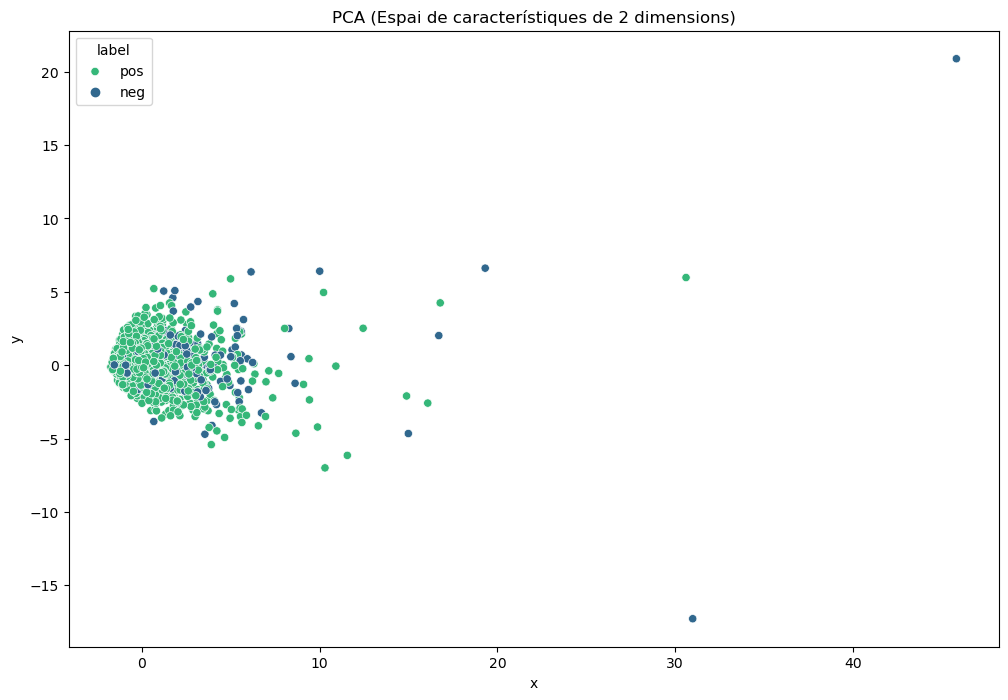

In [ ]:
#Visualización del espacio de características con PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#Visualización del espacio de características con PCA
def plot_PCA_2D(X, y, labels):
    # Crear un pipeline que estandaritzi les dades i després apliqui PCA
    pipe = Pipeline([('scaler', StandardScaler()), ('reducer', PCA(n_components=2))])
    # Ajustar el pipeline a les dades
    pipe.fit(X)
    # Transformar les dades
    pca_data = pipe.transform(X)
    # Crear un dataframe amb les dades transformades
    df = pd.DataFrame({'x': pca_data[:, 0], 'y': pca_data[:, 1], 'label': y})
    # Crear una figura
    plt.figure(figsize=(12, 8))
    # Crear la gràfica de dispersió amb Seaborn
    sns.scatterplot(x='x', y='y', hue='label', data=df, palette='viridis')
    # Afegir títol i llegenda
    plt.title('PCA (Espai de característiques de 2 dimensions)')
    plt.legend(title='label', labels=labels)
    # Mostrar la gràfica
    plt.show()

parameters = {"max_df_values": 1.0, "min_df": 0.1}
print(x_train_count_vectorizer.toarray())
plot_PCA_2D(x_train_count_vectorizer.toarray(), train_y, labels=['pos', 'neg'])

# Millor kernel i C

,Kernel,C,F1 score
0,linear,0.01,0.829972
1,linear,0.10,0.809485
2,linear,1.00,0.806117
3,linear,10.00,0.803135
4,linear,20.00,0.803135
5,poly,0.01,0.892731
6,poly,0.10,0.893218
7,poly,1.00,0.892204
8,poly,10.00,0.875266
9,poly,20.00,0.869813


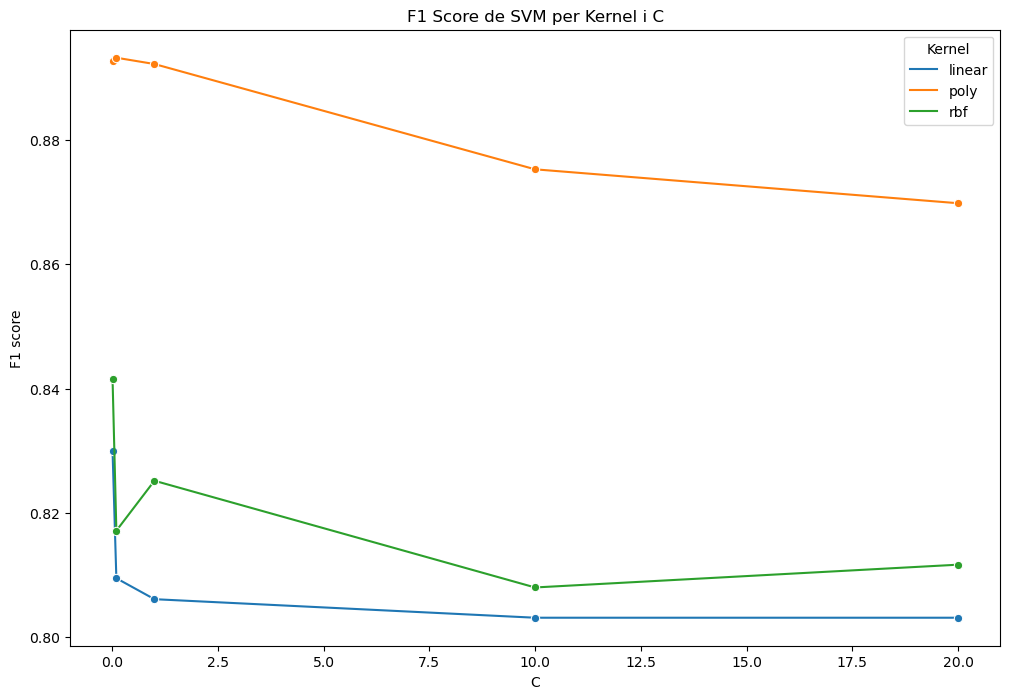

In [ ]:
#Mejor kernel en un rango de valores de C
def find_best_kernel_Crange(train_x, test_x, parameters):
    # Crear un dataframe vacío
    results = pd.DataFrame(columns=['Kernel', 'C', 'F1 score'])
    # Crear una lista de kernels
    kernels = ['linear', 'poly', 'rbf']
    # Crear una lista de valores de C
    C_values = [0.01, 0.1, 1, 10, 20]
    # Iterar sobre los kernels
    for kernel in kernels:
        # Iterar sobre los valores de C
        for C in C_values:
            # Crear el modelo SVM
            svm_model = create_model_svm(train_x, test_x, parameters, C=C, kernel_type=kernel)
            # Obtener las predicciones
            predictions = svm_model.predict(x_test_count_vectorizer)
            # Calcular el F1 score
            f1 = f1_score(test_y, predictions, average='weighted')
            # Añadir los resultados al dataframe
            results.loc[len(results)] = [kernel, C, f1]
    # Mostrar los resultados
    display(results)

    #Gráfica los resultados en forma de función linial NO palette virdis
    plt.figure(figsize=(12, 8))
    sns.lineplot(x='C', y='F1 score', hue='Kernel',marker='o', data=results)
    plt.title('F1 Score de SVM per Kernel i C')
    plt.legend(title='Kernel')
    plt.show()
    
    




# parameters = {"max_df_values": 1.0, "min_df": 0.1}
find_best_kernel_Crange(train_x, test_x, parameters)

,Kernel,C,Specificity
0,linear,0.01,0.474747
1,linear,0.10,0.505051
2,linear,1.00,0.505051
3,linear,10.00,0.494949
4,linear,20.00,0.494949
5,poly,0.01,0.141414
6,poly,0.10,0.202020
7,poly,1.00,0.292929
8,poly,10.00,0.232323
9,poly,20.00,0.191919


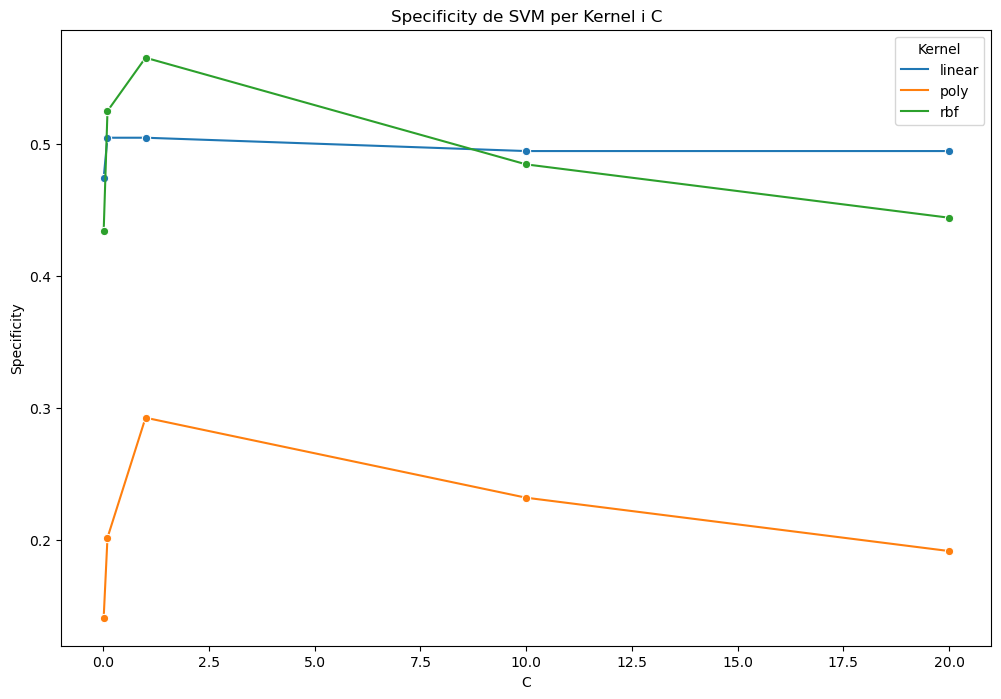

In [ ]:
#specificity de SVM per kernel i C calculada con matriz de confusión
def find_best_kernel_Crange_specificity(train_x, test_x, parameters):
    # Crear un dataframe vacío
    results = pd.DataFrame(columns=['Kernel', 'C', 'Specificity'])
    # Crear una lista de kernels
    kernels = ['linear', 'poly', 'rbf']
    # Crear una lista de valores de C
    C_values = [0.01, 0.1, 1, 10, 20]
    # Iterar sobre los kernels
    for kernel in kernels:
        # Iterar sobre los valores de C
        for C in C_values:
            # Crear el modelo SVM
            svm_model = create_model_svm(train_x, test_x, parameters, C=C, kernel_type=kernel)
            # Obtener las predicciones
            predictions = svm_model.predict(x_test_count_vectorizer)
            # Calcular el F1 score
            tn, fp, fn, tp = confusion_matrix(test_y, predictions).ravel()
            specificity = tn / (tn+fp)
            # Añadir los resultados al dataframe
            results.loc[len(results)] = [kernel, C, specificity]
    # Mostrar los resultados
    display(results)

    #Gráfica los resultados en forma de función linial NO palette virdis
    plt.figure(figsize=(12, 8))
    sns.lineplot(x='C', y='Specificity', hue='Kernel', marker='o', data=results)
    plt.title('Specificity de SVM per Kernel i C')
    plt.legend(title='Kernel')
    plt.show()


find_best_kernel_Crange_specificity(train_x, test_x, parameters)

# Millor gamma

,Gamma,F1 score
0,0.001,0.843448
1,0.010,0.821241
2,0.100,0.810008
3,1.000,0.856372
4,10.000,0.872596
5,20.000,0.872596


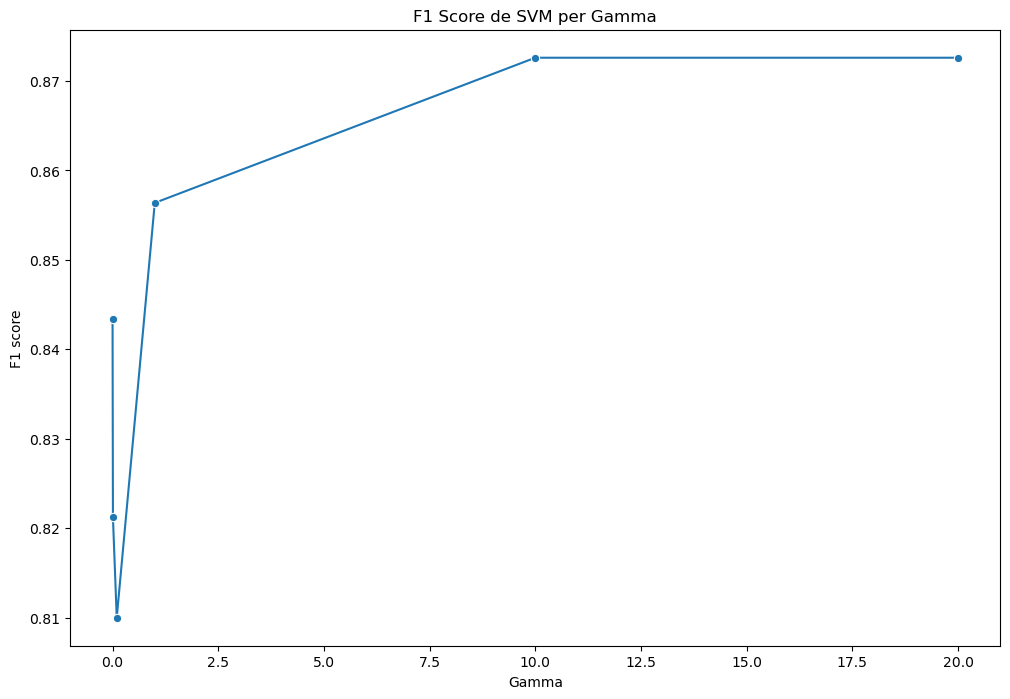

In [ ]:
#Mejor gamma para kernel rbf
def find_best_gamma_rbf(train_x, test_x, parameters):
    # Crear un dataframe vacío
    results = pd.DataFrame(columns=['Gamma', 'F1 score'])
    # Crear una lista de valores de gamma
    gamma_values = [0.001, 0.01, 0.1, 1, 10, 20]
    # Iterar sobre los valores de gamma
    for gamma in gamma_values:
        # Crear el modelo SVM
        svm_model = create_model_svm(train_x, test_x, parameters, C = 1.0, kernel_type='rbf', gamma=gamma)
        # Obtener las predicciones
        predictions = svm_model.predict(x_test_count_vectorizer)
        # Calcular el F1 score
        f1 = f1_score(test_y, predictions, average='weighted')
        # Añadir los resultados al dataframe
        results.loc[len(results)] = [gamma, f1]
    # Mostrar los resultados
    display(results)

    #Gráfica los resultados en forma de función linial NO palette virdis
    plt.figure(figsize=(12, 8))
    sns.lineplot(x='Gamma', y='F1 score', marker='o', data=results)
    plt.title('F1 Score de SVM per Gamma')
    plt.show()

find_best_gamma_rbf(train_x, test_x, parameters)


,Gamma,Specificity
0,0.001,0.424242
1,0.010,0.535354
2,0.100,0.535354
3,1.000,0.070707
4,10.000,0.040404
5,20.000,0.040404


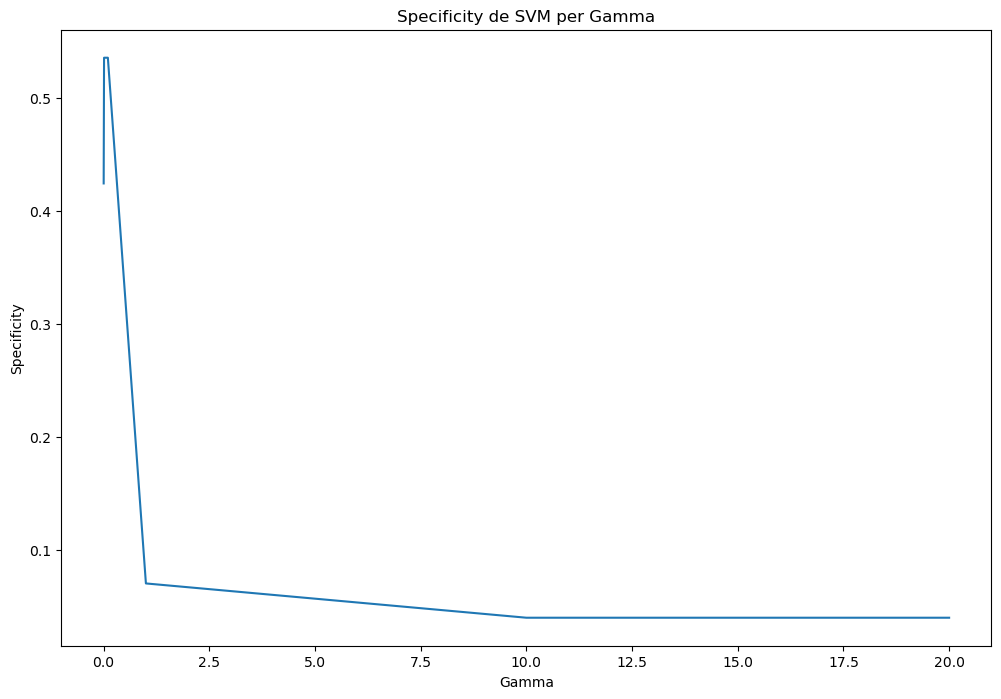

In [ ]:
#Mejor gamma respecto a la especificidad para kernel rbf
def find_best_gamma_rbf_specificity(train_x, test_x, parameters):
    # Crear un dataframe vacío
    results = pd.DataFrame(columns=['Gamma', 'Specificity'])
    # Crear una lista de valores de gamma
    gamma_values = [0.001, 0.01, 0.1, 1, 10, 20]
    # Iterar sobre los valores de gamma
    for gamma in gamma_values:
        # Crear el modelo SVM
        svm_model = create_model_svm(train_x, test_x, parameters,C = 1.0, kernel_type='rbf', gamma=gamma)
        # Obtener las predicciones
        predictions = svm_model.predict(x_test_count_vectorizer)
        # Calcular el F1 score
        tn, fp, fn, tp = confusion_matrix(test_y, predictions).ravel()
        specificity = tn / (tn+fp)
        # Añadir los resultados al dataframe
        results.loc[len(results)] = [gamma, specificity]
    # Mostrar los resultados
    display(results)

    #Gráfica los resultados en forma de función linial NO palette virdis
    plt.figure(figsize=(12, 8))
    sns.lineplot(x='Gamma', y='Specificity', data=results)
    plt.title('Specificity de SVM per Gamma')
    plt.show()

find_best_gamma_rbf_specificity(train_x, test_x, parameters)

# Tamany de les dades - logistic

In [ ]:
def create_model_logistic_TAM(train_x, test_x, train_y, test_y, parameters, train_percent,  results_TAM):
  total_len = len(df)
  # Usar las funciones para obtener características
  x_train_count, x_test_count = create_features_count(train_x, test_x, parameters)
  x_train_tfidf, x_test_tfidf = create_features_TFIDF_word(train_x, test_x)

  # Modelo de regresión logística con CountVectorizer
  logistic_model_count = LogisticRegression(class_weight='balanced')
  logistic_model_count.fit(x_train_count, train_y)
  predictions_count = logistic_model_count.predict(x_test_count)
  f1_score_count = f1_score(test_y, predictions_count, average='weighted')
  tn, fp, fn, tp = confusion_matrix(test_y, predictions_count).ravel()
  specificity = tn / (tn+fp)
  #save the results
  results_TAM.loc[len(results_TAM)] = ["Test", (train_percent), f1_score_count, specificity]


  # Modelo de regresión logística con CountVectorizer y datos train
  logistic_model_count_train = LogisticRegression(class_weight='balanced')
  logistic_model_count_train.fit(x_train_count, train_y)
  predictions_count_train = logistic_model_count.predict(x_train_count)
  f1_score_count_train = f1_score(train_y, predictions_count_train, average='weighted')
  #specifity
  tn_train, fp_train, fn_train, tp_train = confusion_matrix(train_y, predictions_count_train).ravel()
  specificity_train = tn_train / (tn_train+fp_train)

  
  #save the results
  results_TAM.loc[len(results_TAM)] = ["Train", (train_percent), f1_score_count_train, specificity_train]

  return logistic_model_count

In [ ]:
parameters = {"max_df_values": 1.0, "min_df": 0.1, "max_features": 5000}
total_len = len(df)

#list of train percentages from 50/total_len to 4000/total_len with a step of 200/total_len
train_percents = []
for i in range(100, 4000, 20):
  train_percents.append(i/total_len)

results_TAM = pd.DataFrame(columns=["Train/test", "Train percent", "F1 score", "specifity"])

for train_percent in train_percents:
    #print("Train percent:", train_percent)
    # split the data with train_percent
    X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=train_percent, random_state=42)
    # create the model using create_model_logistic 
    loj_model_count = create_model_logistic_TAM(X_train, X_test, y_train, y_test, parameters, train_percent, results_TAM)

    




In [ ]:
results_TAM.head(100)

,Train/test,Train percent,F1 score,specifity
0,Test,0.020346,0.743088,0.379386
1,Train,0.020346,0.921597,1.000000
2,Test,0.024415,0.777245,0.178022
3,Train,0.024415,0.889456,1.000000
4,Test,0.028484,0.774080,0.192478
...,...,...,...,...
95,Train,0.211597,0.769790,0.705882
96,Test,0.215666,0.828663,0.169444
97,Train,0.215666,0.778686,0.650943
98,Test,0.219736,0.796457,0.697479


/var/folders/fc/19xj87mj5vz1jr46yg3ty4740000gn/T/ipykernel_93219/1190077554.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Train percent', y='specifity', hue='Train/test', data=results_TAM, ci=None)


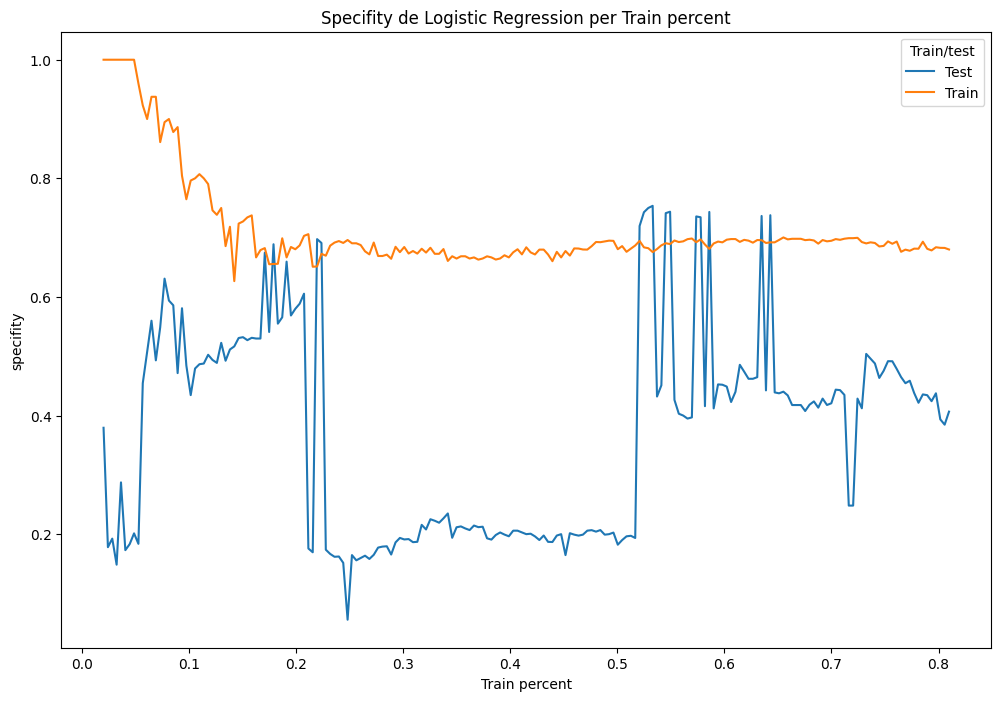

/var/folders/fc/19xj87mj5vz1jr46yg3ty4740000gn/T/ipykernel_93219/1190077554.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Train percent', y='F1 score', hue='Train/test', data=results_TAM, ci=None)


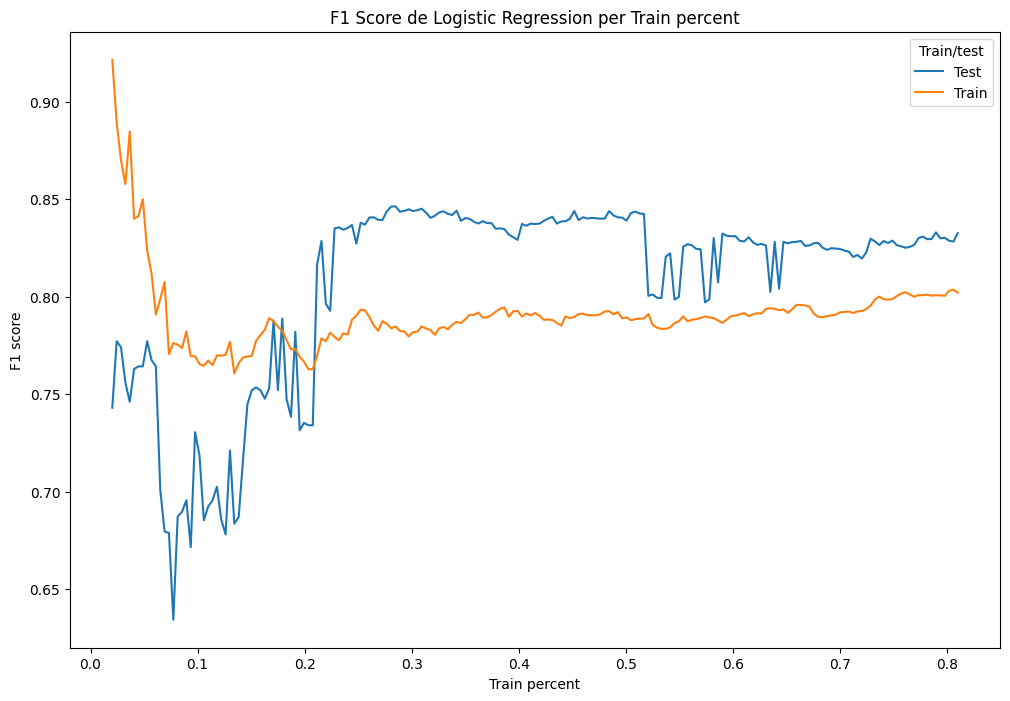

In [ ]:
results_train_TAM = results_TAM[results_TAM['Train/test'] == 'Train']
results_test_TAM = results_TAM[results_TAM['Train/test'] == 'Test']



#specifity per train percent
plt.figure(figsize=(12, 8))
sns.lineplot(x='Train percent', y='specifity', hue='Train/test', data=results_TAM, ci=None)
plt.legend(title='Train/test')
plt.title('Specifity de Logistic Regression per Train percent')
plt.show()


# plot f1 score per train percent
plt.figure(figsize=(12, 8))
sns.lineplot(x='Train percent', y='F1 score', hue='Train/test', data=results_TAM, ci=None)
plt.title('F1 Score de Logistic Regression per Train percent')
plt.legend(title='Train/test')
plt.show()
